# Random Forest Regressor

---

**Источники:**

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

[1.11.2. Forests of randomized trees](https://scikit-learn.org/stable/modules/ensemble.html#forest)


[Random Forest Regression](https://medium.com/swlh/random-forest-and-its-implementation-71824ced454f)

[Painless Random Forest Regression in Python – Step-by-Step with Sklearn](https://onestopdataanalysis.com/python-random-forest-regression/)

[Random forest](https://ru.wikipedia.org/wiki/Random_forest)

[Бэггинг](https://ru.wikipedia.org/wiki/%D0%91%D1%8D%D0%B3%D0%B3%D0%B8%D0%BD%D0%B3)

[How to Visualize a Decision Tree from a Random Forest in Python using Scikit-Learn](https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c)

---


## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn -y

In [3]:
# !conda install -c conda-forge shap -y

In [4]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [5]:
import numpy as np

np.__version__

'1.20.2'

In [6]:
import pandas as pd

pd.__version__

'1.2.4'

In [7]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [8]:
import seaborn as sns

sns.__version__

'0.11.1'

In [9]:
import shap

shap.__version__

'0.39.0'

In [10]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Загрузка данных

[Источник (Calculate Concrete Strength)](https://www.kaggle.com/prathamtripathi/regression-with-neural-networking)

In [11]:
df = pd.read_csv("./../../data/concrete_data.csv")
df

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


## Разделение данных на `X` и `y`

In [12]:
target = 'Strength'

In [13]:
from sklearn.model_selection import train_test_split

y = df[target].copy()
X = df.drop(columns=[target]).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
X

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360
...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28


In [15]:
y

0       79.99
1       61.89
2       40.27
3       41.05
4       44.30
        ...  
1025    44.28
1026    31.18
1027    23.70
1028    32.77
1029    32.40
Name: Strength, Length: 1030, dtype: float64

## Random Forest (Случайный лес) Regressor

[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Основная идея заключается в использовании большого **ансамбля решающих деревьев (decision tree)**, каждое из которых само по себе даёт очень невысокое качество, но за счёт их большого количества результат получается хорошим.

Алгоритм применяется для задач **классификации, регрессии и кластеризации**.

**Достоинства:**
- Способность эффективно обрабатывать данные с большим числом признаков и классов.
- Нечувствительность к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков.
- Одинаково хорошо обрабатываются как непрерывные, так и дискретные признаки. Существуют методы построения деревьев по данным с пропущенными значениями признаков.
- Существуют методы оценивания значимости отдельных признаков в модели.
- Внутренняя оценка способности модели к обобщению (тест по неотобранным образцам out-of-bag).
- Высокая параллелизуемость и масштабируемость.

**Недостатки:**
- Большой размер получающихся моделей. Требуется $O(K)$ памяти для хранения модели, где $K$ — число деревьев.

<center><img src="images/random_forest.png"/></center>

---

<center><img src="images/random_forest_2.png"/></center>

<center><img src="images/random_forest_regression_line.png"/></center>

## Анализ и обработка выбросов

In [16]:
def remove_outliers_iqr(data, col_name):
    print(f"column name: {col_name}\n")
    Q1 = data[col_name].quantile(0.25)
    Q3 = data[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    data_new = data[~((data[col_name] < lower_fence) |
                      (data[col_name] > upper_fence))]
    
    diff_len = len(data) - len(data_new)
    print(f"removed: {diff_len}")
    
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data_new[col_name], ax=axs[0])
    sns.histplot(data=data_new[col_name], ax=axs[1])
    
    return data_new.reset_index(drop=True)

## Анализ числовых признаков

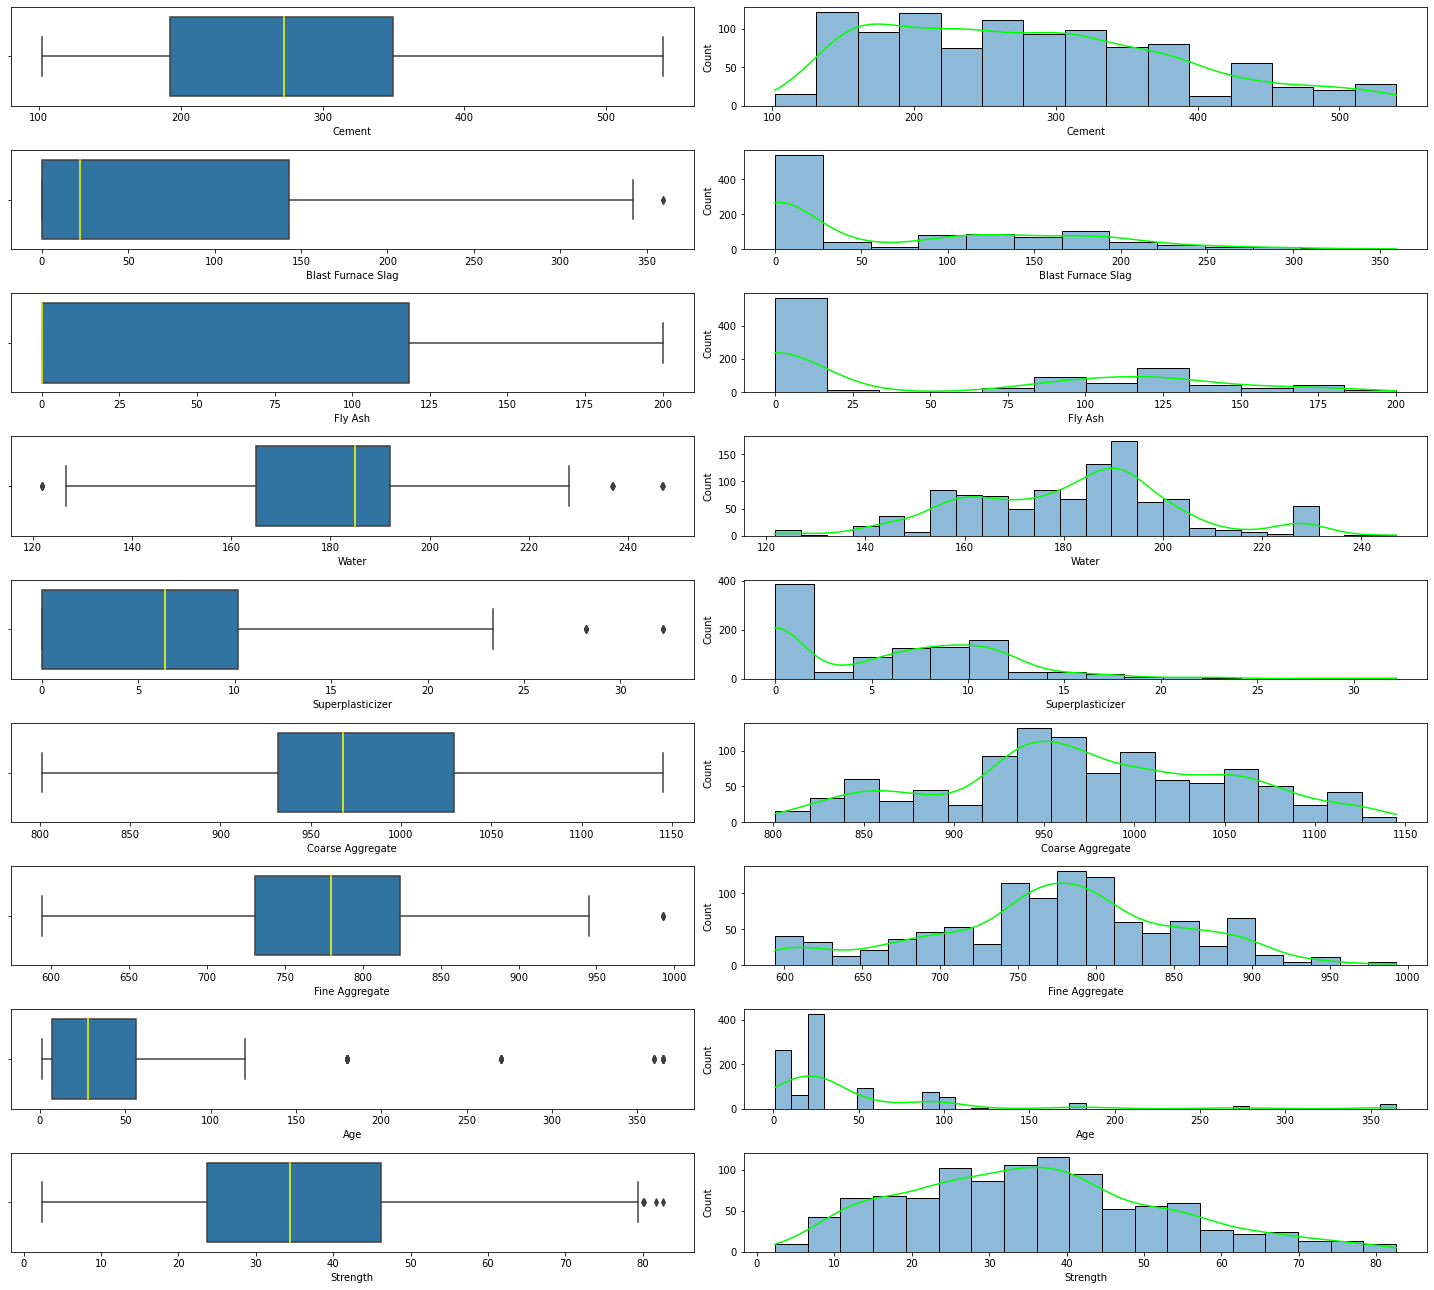

In [17]:
num_cols = df.select_dtypes(include=np.number).columns.to_list()
fig, axs = plt.subplots(len(num_cols), 2, figsize=(20, 2 * len(num_cols)))

for index, column_name in enumerate(num_cols):
    sns.boxplot(x=df[column_name], ax=axs[index][0])
    axs[index][0].get_lines()[4].set_color('yellow')
    
    sns.histplot(x=df[column_name], kde=True, ax=axs[index][1])
    axs[index][1].get_lines()[0].set_color('lime')
    
fig.tight_layout(pad=1.0)

## Анализ корреляций

In [18]:
corr = X.corr(method='spearman')
corr

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
Cement,1.000000,-0.245167,-0.418320,-0.094437,0.037919,-0.144880,-0.173596,0.004640
Blast Furnace Slag,-0.245167,1.000000,-0.253551,0.053360,0.098137,-0.348898,-0.302278,-0.017581
Fly Ash,-0.418320,-0.253551,1.000000,-0.283150,0.454091,0.058366,0.051307,0.002801
Water,-0.094437,0.053360,-0.283150,1.000000,-0.686923,-0.218487,-0.345614,0.090942
Superplasticizer,0.037919,0.098137,0.454091,-0.686923,1.000000,-0.198802,0.168313,-0.009525
Coarse Aggregate,-0.144880,-0.348898,0.058366,-0.218487,-0.198802,1.000000,-0.100480,-0.044928
Fine Aggregate,-0.173596,-0.302278,0.051307,-0.345614,0.168313,-0.100480,1.000000,-0.057362
Age,0.004640,-0.017581,0.002801,0.090942,-0.009525,-0.044928,-0.057362,1.000000


<AxesSubplot:>

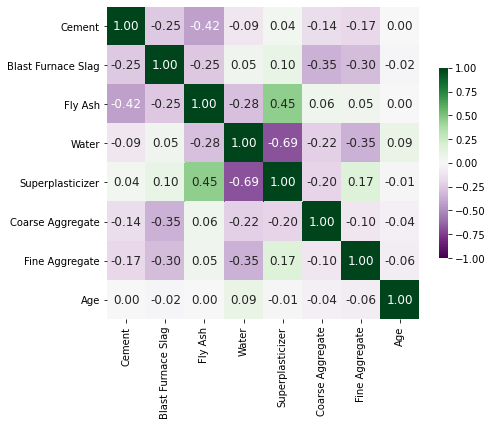

In [19]:
plt.figure(figsize=(7, 7))

sns.heatmap(corr, 
            square=True,
            annot=True,
            fmt='.2f',
            cmap='PRGn',
            cbar_kws={"shrink": .5},
            annot_kws={"size": 12},
            robust=True,
            vmin=-1, 
            vmax=1)

## Анализ отсутствующих значений

In [20]:
X.isna().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
dtype: int64

In [21]:
y.isna().sum()

0

Выводы: Отсутствующих значений нет.

## Важные параметры [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

- `n_estimators: int, default=100`
    - Количество деревьев в лесу.
    
    
- `criterion: {"mse", "mae"}, default="mse"`
    - Функция измерения качества разделения.
    - Поддерживаемые критерии: `"mse"` для среднеквадратичной ошибки, которая равна уменьшению дисперсии в качестве критерия выбора признаков, и `"mae"` для средней абсолютной ошибки.
    
    
- `max_depth: int, default=None`
    - Максимальная глубина дерева.
    - Если `None`, то узлы расширяются до тех пор, пока все листья не станут чистыми или пока все листья не будут содержать менее `min_samples_split` выборок.
    
   
- `min_samples_split: int или float, default=2`
    - Минимальное количество выборок, необходимое для разделения внутреннего узла:
        - Если `int`, то считает `min_samples_split` минимальным числом.
        - Если `float`, то `min_samples_split` - это дробь, а `ceil(min_samples_split * n_samples)` - минимальное количество выборок для каждого разделения.
        
        
- `min_samples_leaf: int or float, default=1`
    - Минимальное количество выборок, которое требуется для конечного узла.
    - Точка разделения на любой глубине будет учитываться только в том случае, если она оставляет не менее `min_samples_leaf` обучающих выборок в каждой из левой и правой ветвей. Это может иметь эффект сглаживания модели, особенно при регрессии.
    - Если `int`, то считает `min_samples_leaf` минимальным числом.
    - Если `float`, то `min_samples_leaf` - дробная часть, а `ceil(min_samples_leaf * n_samples)` - минимальное количество выборок для каждого узла.
    
    
- `min_weight_fraction_leaf: float, default=0.0`


- `max_features: {"auto", "sqrt", "log2"}, int or float, default="auto"`


- `max_leaf_nodes: int, default=None`
    - Выращиевает деревья с `max_leaf_nodes` способом "лучший первый" (best-first).
    - Лучшие узлы определяются как относительное уменьшение "загрязнения" (impurity).
    - Если `None`, то неограниченное количество конечных узлов.

## Обучение модели (Train) - manual

In [55]:
# импортировать пакет RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# создать объект RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, 
                              max_depth=5)

# обучить модель
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10)

## Оценка качества модели (Evaluation)

In [56]:
# использовать обученную модель для предсказания на test выборке
y_test_predicted = model.predict(X_test)
y_train_predicted = model.predict(X_train)

In [57]:
print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")

R2 (train): 0.8768529336868508
R2 (test): 0.8077305530896304
MSE (train): 34.22592942767022
MSE (test): 53.6846202521133


Для визуализации необходимо установить [`Graphviz`](https://graphviz.gitlab.io/download/).

In [58]:
from sklearn.tree import export_graphviz
import os

for i, est in enumerate(model.estimators_):
    export_graphviz(est,
                    out_file=f'tmp/rf_tree_{i}.dot', 
                    feature_names = X_train.columns.to_list(),
                    class_names = y_train.name,
                    rounded = True, 
                    proportion = False, 
                    precision = 2,
                    special_characters=True,
                    filled = True)
    os.system(f'dot -Tpng tmp/rf_tree_{i}.dot -o tmp/rf_tree_{i}.png')

## Важность признаков

### Важность признаков на основе среднего уменьшения примесей (mean decrease in impurity)

Важность признаков обеспечивается соответствующим атрибутом `feature_importances_`, и они вычисляются как среднее значение и стандартное отклонение накопления уменьшения примесей в каждом дереве.

**ВНИМАНИЕ:** Важность признаков на основе примесей может вводить в заблуждение для **признаков с высокой мощностью** (много уникальных значений).

In [59]:
feature_names = X_train.columns
feature_names

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age'],
      dtype='object')

In [60]:
importances = model.feature_importances_
importances

array([0.30232402, 0.05422526, 0.0138919 , 0.1324214 , 0.05686557,
       0.01245784, 0.02442391, 0.4033901 ])

In [61]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], 
             axis=0)

std

array([0.07051901, 0.02378199, 0.01249596, 0.05204887, 0.04432422,
       0.00898124, 0.01297711, 0.04624333])

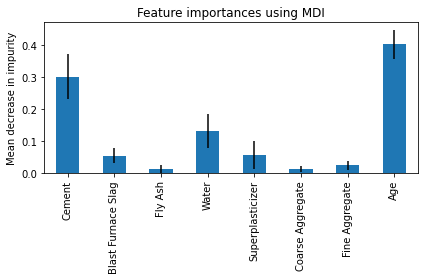

In [62]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Важность признаков на основе перестановки признаков (feature permutation)

Такой подход преодолевает ограничения важности признака на основе примесей: признаки не имеют предвзятости в сторону признаков с высокой мощностью и могут быть вычислены на оставленном наборе тестов.

[sklearn.inspection.permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

Вычисление важности полной перестановки **более затратно: признаки перемешиваются `n` раз**, и модель перестраивается, чтобы оценить их важность.

При использовании обоих методов одни и те же признаки определяются как наиболее важные. Хотя относительные значения различаются.

In [63]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10)

result

{'importances_mean': array([0.42149043, 0.0802779 , 0.00439027, 0.15659877, 0.06449313,
        0.00506027, 0.02340295, 0.70758987]),
 'importances_std': array([0.02446132, 0.00865165, 0.00265365, 0.01561587, 0.0078925 ,
        0.0015204 , 0.00219909, 0.0367346 ]),
 'importances': array([[ 4.09442384e-01,  4.21517819e-01,  3.90525394e-01,
          4.27788367e-01,  4.59539955e-01,  4.20445846e-01,
          4.54086077e-01,  3.93124961e-01,  3.91706446e-01,
          4.46727092e-01],
        [ 7.80940189e-02,  9.56876943e-02,  7.24372118e-02,
          7.83448562e-02,  8.83950886e-02,  7.74971110e-02,
          8.92413274e-02,  6.42505973e-02,  8.32063165e-02,
          7.56248216e-02],
        [ 4.36307342e-03,  2.37423490e-03,  4.42023415e-03,
         -5.30663841e-05,  6.59313777e-03,  3.77352062e-03,
          9.74544088e-03,  4.94849157e-03,  1.43538026e-03,
          6.30222585e-03],
        [ 1.91307311e-01,  1.73154378e-01,  1.61531358e-01,
          1.34363851e-01,  1.47178128

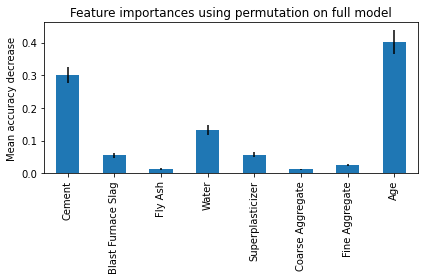

In [64]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()

### [SHAP](https://github.com/slundberg/shap)

In [68]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

In [75]:
choosen_instance = X_train.iloc[[1]]
choosen_instance

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
370,218.9,0.0,124.1,158.5,11.3,1078.7,794.9,14


AssertionError: Feature and SHAP matrices must have the same number of rows!

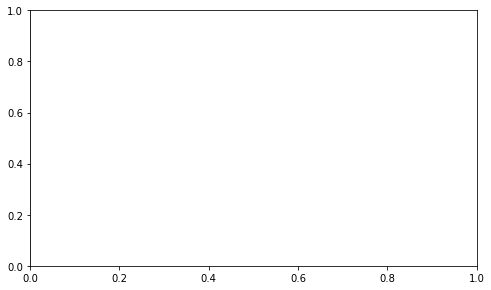

In [85]:
shap.summary_plot(shap_values, X_train)

In [76]:
shap_values = explainer.shap_values(choosen_instance)

In [82]:
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

## Feature Selection

In [32]:
selector = SelectKBest(score_func=mutual_info_regression, k=6).fit(X_train, y_train)

In [33]:
X_train_new = selector.transform(X_train)
X_train_new

array([[ 150. ,  237. ,  174. ,   12. , 1069. ,   28. ],
       [ 218.9,    0. ,  158.5,   11.3, 1078.7,   14. ],
       [ 339. ,    0. ,  197. ,    0. ,  968. ,  365. ],
       ...,
       [ 190.3,    0. ,  166.6,    9.9, 1079. ,  100. ],
       [ 475. ,  118.8,  181.1,    8.9,  852.1,   28. ],
       [ 314. ,    0. ,  170. ,   10. ,  925. ,   28. ]])

In [34]:
feat_scores = pd.DataFrame({'score': selector.scores_}, index=X_train.columns).sort_values(by='score', 
                                                                    ascending=False)
feat_scores

,score
Water,0.325142
Age,0.304922
Cement,0.225776
Blast Furnace Slag,0.192978
Superplasticizer,0.172760
Coarse Aggregate,0.162619
Fine Aggregate,0.150519
Fly Ash,0.041072


<AxesSubplot:>

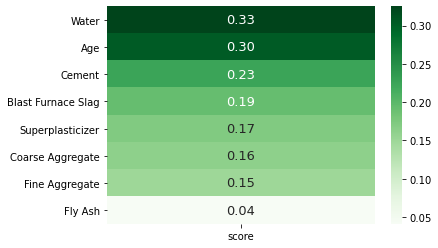

In [35]:
sns.heatmap(feat_scores, annot=True, 
            annot_kws={"size": 13}, 
            fmt="1.2f", 
            cmap='Greens')

In [36]:
pd.DataFrame(X_train_new)

,0,1,2,3,4,5
0,150.0,237.0,174.0,12.0,1069.0,28.0
1,218.9,0.0,158.5,11.3,1078.7,14.0
2,339.0,0.0,197.0,0.0,968.0,365.0
3,143.8,136.3,178.1,7.5,941.5,28.0
4,252.5,0.0,185.7,0.0,1111.6,7.0
...,...,...,...,...,...,...
685,286.3,200.9,144.7,11.2,1004.6,3.0
686,246.8,0.0,143.3,12.0,1086.8,14.0
687,190.3,0.0,166.6,9.9,1079.0,100.0
688,475.0,118.8,181.1,8.9,852.1,28.0


In [37]:
X_train

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
900,150.0,237.0,0.0,174.0,12.0,1069.0,675.0,28
370,218.9,0.0,124.1,158.5,11.3,1078.7,794.9,14
604,339.0,0.0,0.0,197.0,0.0,968.0,781.0,365
973,143.8,136.3,106.2,178.1,7.5,941.5,774.3,28
593,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,7
...,...,...,...,...,...,...,...,...
87,286.3,200.9,0.0,144.7,11.2,1004.6,803.7,3
330,246.8,0.0,125.1,143.3,12.0,1086.8,800.9,14
466,190.3,0.0,125.2,166.6,9.9,1079.0,798.9,100
121,475.0,118.8,0.0,181.1,8.9,852.1,781.5,28


## Обучение модели (Train) - pipeline

In [38]:
param_grid = {'model__max_depth': [5, 8, 11], 
              'model__n_estimators': [50, 100], 
              'model__criterion': ["mse", "mae"]}

In [39]:
pipeline = Pipeline(steps = [
#             ('fs', SelectKBest(score_func=f_regression, k=5)),
            ('fs', SelectKBest(score_func=mutual_info_regression, k=6)),

            ('model', RandomForestRegressor())
        ])

In [40]:
model_gs = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

In [41]:
model_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('fs',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x7f954c745040>)),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['mse', 'mae'],
                         'model__max_depth': [5, 8, 11],
                         'model__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [42]:
print(f"best_params: {model_gs.best_params_}")
print(f"best_score: {model_gs.best_score_:0.2f}\n")

best_params: {'model__criterion': 'mse', 'model__max_depth': 11, 'model__n_estimators': 100}
best_score: -28.79



In [43]:
pd.DataFrame(model_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.131868,0.007208,0.007707,0.000145,mse,5,50,"{'model__criterion': 'mse', 'model__max_depth'...",-49.458635,-43.904124,-57.541064,-47.200078,-41.630726,-47.946925,5.497803,9
1,0.204354,0.001766,0.011954,0.000257,mse,5,100,"{'model__criterion': 'mse', 'model__max_depth'...",-50.888763,-41.323302,-56.711014,-47.507640,-44.554226,-48.196989,5.305220,10
2,0.145329,0.008282,0.008018,0.000322,mse,8,50,"{'model__criterion': 'mse', 'model__max_depth'...",-35.307445,-27.909554,-39.544295,-27.918882,-27.039397,-31.543915,4.996206,6
3,0.240230,0.005941,0.012445,0.000174,mse,8,100,"{'model__criterion': 'mse', 'model__max_depth'...",-33.199091,-29.190826,-38.959674,-28.276376,-27.615005,-31.448194,4.226996,5
4,0.143628,0.003176,0.008174,0.000233,mse,11,50,"{'model__criterion': 'mse', 'model__max_depth'...",-32.809016,-29.365640,-36.471835,-26.490164,-24.054700,-29.838271,4.420688,2
5,0.270690,0.010850,0.013754,0.000914,mse,11,100,"{'model__criterion': 'mse', 'model__max_depth'...",-33.066913,-26.057824,-36.225896,-23.646657,-24.940315,-28.787521,4.946177,1
6,0.419615,0.034385,0.008426,0.001144,mae,5,50,"{'model__criterion': 'mae', 'model__max_depth'...",-52.345159,-43.254770,-52.792112,-51.600815,-47.557529,-49.510077,3.636535,11
7,0.822566,0.061266,0.012845,0.000640,mae,5,100,"{'model__criterion': 'mae', 'model__max_depth'...",-55.227987,-44.352050,-57.665960,-49.457125,-47.822064,-50.905037,4.877310,12
8,0.476802,0.020106,0.008522,0.001280,mae,8,50,"{'model__criterion': 'mae', 'model__max_depth'...",-39.962404,-31.090621,-37.781818,-33.302755,-30.205156,-34.468551,3.797531,8
9,0.921248,0.051099,0.014008,0.001247,mae,8,100,"{'model__criterion': 'mae', 'model__max_depth'...",-37.400087,-31.595667,-39.739712,-31.008137,-29.359853,-33.820691,4.015150,7


## Оценка качества модели (Evaluation)

In [44]:
# использовать обученную модель для предсказания на test выборке
y_test_predicted = model_gs.predict(X_test)
y_train_predicted = model_gs.predict(X_train)

In [45]:
print(f'R2 (train): {r2_score(y_train, y_train_predicted)}')
print(f'R2 (test): {r2_score(y_test, y_test_predicted)}')

print(f"MSE (train): {mean_squared_error(y_train, y_train_predicted, squared=True)}")
print(f"MSE (test): {mean_squared_error(y_test, y_test_predicted, squared=True)}")

R2 (train): 0.9824516247711451
R2 (test): 0.8862836051610641
MSE (train): 4.877172231011829
MSE (test): 31.75138625230217
